In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import r2_score

import sys
sys.path.append('/home/jshe/prop-pred/src/data')
from data_utils import *

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from models import *

from bayesian_torch.models.dnn_to_bnn import dnn_to_bnn, get_kl_loss

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

%load_ext autoreload
%autoreload 2

## Data

In [2]:
datadir = '../../data/regress_immuno'
data = to_namedtuple(to_tensor(load_data(datadir), device))

In [3]:
train_X = torch.concat((
    data.train.embeddings, 
    data.train.fingerprints, 
), axis=1)
validation_X = torch.concat((
    data.validation.embeddings, 
    data.validation.fingerprints, 
), axis=1)
test_X = torch.concat((
    data.test.embeddings, 
    data.test.fingerprints, 
), axis=1)

In [4]:
train_Y = data.train.y
validation_Y = data.validation.y
test_Y = data.test.y

## Model

In [5]:
bnn_params = {
    "prior_mu": 0.0,
    "prior_sigma": 1.0,
    "posterior_mu_init": 0.0,
    "posterior_rho_init": -3.0,
    "type": "Reparameterization",  # Flipout or Reparameterization
    "moped_enable": False,  # True to initialize mu/sigma from the pretrained dnn weights
    "moped_delta": 0.5,
}

model = RMLP(
    in_features=train_X.shape[1], out_features=train_Y.shape[1], 
    depth=2, width=512, dropout=0.4
).to(device)
dnn_to_bnn(model, bnn_params)
model.to(device);

## Train

In [6]:
dataloader = DataLoader(TensorDataset(train_X, train_Y), batch_size=64, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses, validation_losses, validation_scores = [], [], []
for epoch in tqdm(range(128)):
    model.train()
    for train_x, train_y in dataloader:
        optimizer.zero_grad()

        y_pred = model(train_x)
        kl = get_kl_loss(model)
        mse = nn.functional.mse_loss(y_pred, train_y)
        loss = mse + kl / 64

        loss.backward()
        optimizer.step()

    model.eval()

    # Train Loss
    Y_pred = model(train_X)
    kl = get_kl_loss(model)
    mse = nn.functional.mse_loss(Y_pred, train_Y)
    train_losses.append(float(mse + kl / train_X.shape[0]))

    # Validation Loss
    Y_pred = model(validation_X)
    kl = get_kl_loss(model)
    mse = nn.functional.mse_loss(Y_pred, validation_Y)
    validation_losses.append(float(mse + kl / validation_Y.shape[0]))
    validation_scores.append(r2_score(
        validation_Y.detach().cpu(), Y_pred.detach().cpu(), 
        multioutput='raw_values'
    ))

    # Early stopping
    stop_interval = 16
    if epoch > stop_interval // 2 and epoch % (stop_interval // 2) == 0:
        x = torch.arange(0, stop_interval) - (stop_interval / 2) + 0.5
        y = torch.tensor(validation_losses[-stop_interval:])
        if x @ y > 0: break

 31%|█████████████▏                            | 40/128 [00:11<00:24,  3.61it/s]


Text(0.5, 0, 'Epoch')

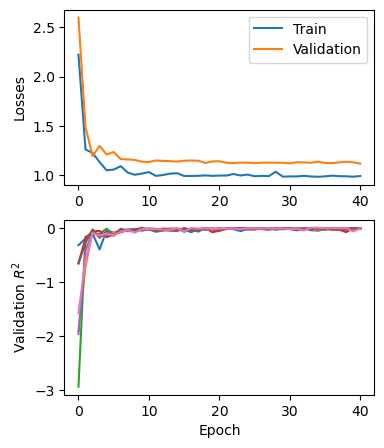

In [7]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(4, 5))
ax0.plot(train_losses, label='Train')
ax0.plot(validation_losses, label='Validation')
ax0.set_ylabel('Losses')
ax0.legend()
ax1.plot(validation_scores)
ax1.set_ylabel(r'Validation $R^2$')
ax1.set_xlabel('Epoch')

## Visualization

In [8]:
x, y_true = test_X, test_Y

y_pred = model(test_X).detach()
scores = r2_score(test_Y.detach().cpu(), y_pred.detach().cpu(), multioutput='raw_values')

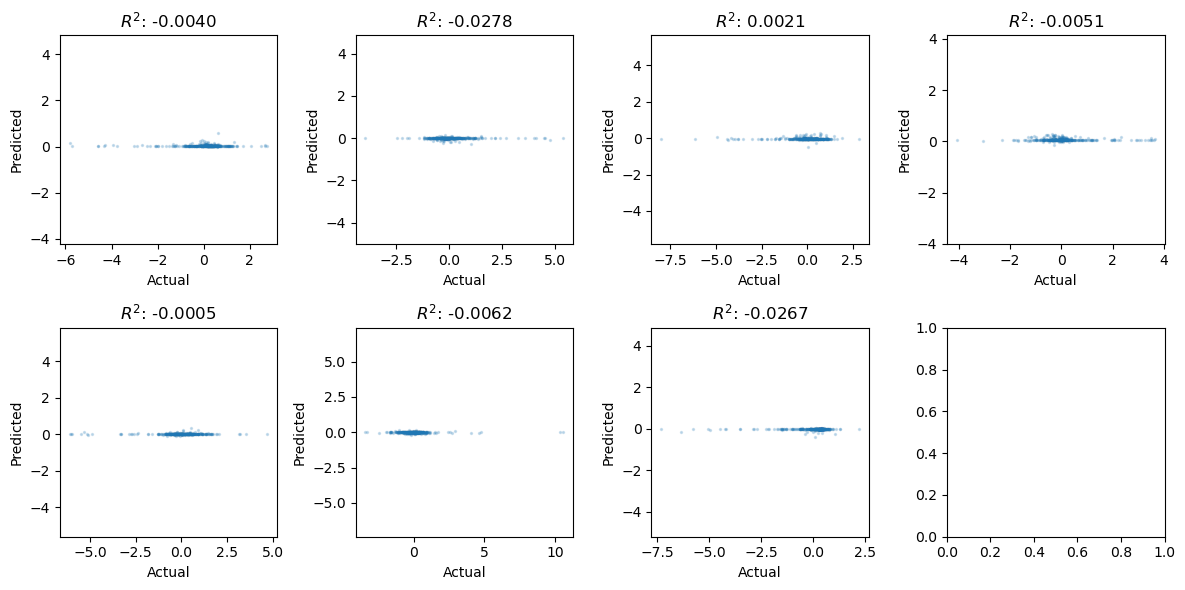

In [9]:
n_rows = n_cols = int((y_pred.shape[1]) ** 0.5)
while (n_rows * n_cols) < y_pred.shape[1]: n_cols += 1

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3))
axs = [axs] if y_pred.shape[1] == 1 else axs.flatten()

for i in range(y_pred.shape[1]):

    ax = axs[i]

    ax.scatter(y_true[:, i].cpu(), y_pred[:, i].cpu(), s=2, alpha=0.2)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title(f'$R^2$: {scores[i]:.4f}')
    ax.set_aspect('equal', adjustable='datalim')

plt.tight_layout()